# Super Piano 3: Google Music Transformer
## Generating Music with Long-Term structure
### Based on 2019 ICLR paper by Cheng-Zhi Anna Huang, Google Brain and Damon Gwinn's code/repo https://github.com/gwinndr/MusicTransformer-Pytorch

Huge thanks go out to the following people who contributed the code/repos used in this colab. Additional contributors are listed in the code as well.

1) Kevin-Yang https://github.com/jason9693/midi-neural-processor

2) gudgud96 for fixing Kevin's MIDI Encoder properly https://github.com/gudgud96

2) jinyi12, Zac Koh, Akamight, Zhang https://github.com/COMP6248-Reproducability-Challenge/music-transformer-comp6248

Thank you so much for your hard work and for sharing it with the world :)


###Setup Environment and Dependencies. Check GPU.

In [7]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [1]:
#@title Check if GPU (driver) is avaiiable (you do not want to run this on CPU, trust me)
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
Mon Jun  5 08:19:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   47C    P8    19W / 250W |      2MiB / 12212MiB |      0%      Default |
|                               |      

In [ ]:
#@title Clone/Install all dependencies
!git clone https://github.com/asigalov61/midi-neural-processor
#!git clone https://github.com/asigalov61/MusicTransformer-Pytorch
!pip install tqdm
!pip install progress
!pip install pretty-midi
!pip install pypianoroll
!pip install matplotlib
!pip install librosa
!pip install scipy
!pip install pillow
!apt install fluidsynth #Pip does not work for some reason. Only apt works
!pip install midi2audio
!pip install mir_eval
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

In [2]:
#@title Import all needed modules
import numpy as np
import pickle
import os
import sys
import math
import random
# For plotting
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
#%matplotlib inline
#matplotlib.get_backend()
import mir_eval.display
import librosa
import librosa.display
# For rendering output audio
import pretty_midi
from midi2audio import FluidSynth
#from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

#Train the Model

In [ ]:
#@title Activate Tensorboard Graphs/Stats to monitor/evaluate model perfomance during and after training runs
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
%tensorboard --logdir /content/MusicTransformer-Pytorch/rpr

In [ ]:
#@title Start to Train the Model
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 500 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
!python3 train.py -output_dir ./output -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence  #-n_layers -num_heads -d_model -dim_feedforward

In [1]:
#@title Re-Start Training from a certain checkpoint and epoch
batch_size = 4 #@param {type:"slider", min:0, max:8, step:1}
number_of_training_epochs = 500 #@param {type:"slider", min:0, max:200, step:1}
maximum_output_MIDI_sequence = 2048 #@param {type:"slider", min:0, max:8192, step:128}
saved_checkpoint_full_path = "./output/weights/epoch_0493.pickle" #@param {type:"string"}
continue_epoch_number = 493 #@param {type:"integer"}

!python3 train.py -output_dir ./output -batch_size=$batch_size -epochs=$number_of_training_epochs -max_sequence=$maximum_output_MIDI_sequence -continue_weights $saved_checkpoint_full_path -continue_epoch $continue_epoch_number #-n_layers -num_heads -d_model -dim_feedforward

input_dir: ./dataset
output_dir: ./output
weight_modulus: 1
print_modulus: 1

n_workers: 1
force_cpu: False
tensorboard: True

continue_weights: ./output/weights/epoch_0493.pickle
continue_epoch: 493

lr: None
ce_smoothing: None
batch_size: 4
epochs: 500

rpr: False
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024
dropout: 0.1

NEW EPOCH: 494

Epoch 494  Batch 1 / 499
LR: 8.910260564395426e-05
Train loss: 0.8978692889213562

Time (s): 1.0134024620056152

Epoch 494  Batch 2 / 499
LR: 8.910242454753869e-05
Train loss: 0.6205321550369263

Time (s): 0.5629901885986328

Epoch 494  Batch 3 / 499
LR: 8.910224345222733e-05
Train loss: 0.7072031497955322

Time (s): 0.5632383823394775

Epoch 494  Batch 4 / 499
LR: 8.910206235802017e-05
Train loss: 0.5450633764266968

Time (s): 0.5661189556121826

Epoch 494  Batch 5 / 499
LR: 8.910188126491717e-05
Train loss: 0.7497311234474182

Time (s): 0.5639288425445557

Epoch 494  Batch 6 / 499
LR: 8.910170017291837e-05
Train l

###Evaluate the resulted models

In [ ]:
#@title Evaluate Best Resulting Accuracy Model (best_acc_weights.pickle)
!python3 evaluate.py -model_weights ./output/results/best_acc_weights.pickle #--rpr

In [ ]:
#@title Evaluate Best Resulting Loss Model (best_loss_weights.pickle)
!python3 evaluate.py -model_weights ./output/results/best_loss_weights.pickle #--rpr

Creation of the directory ./output/results failed


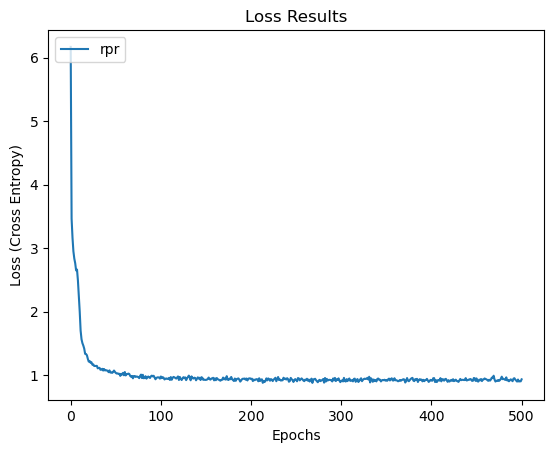

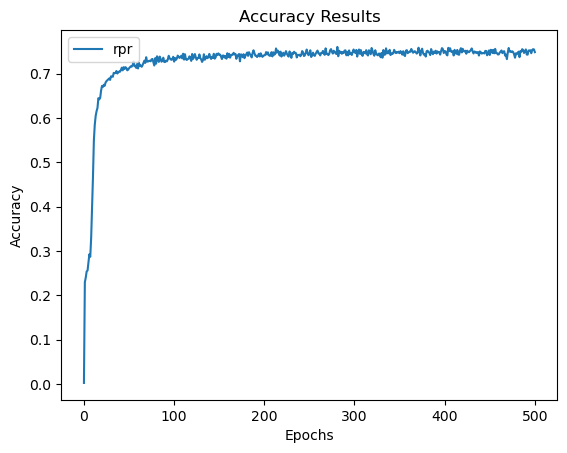

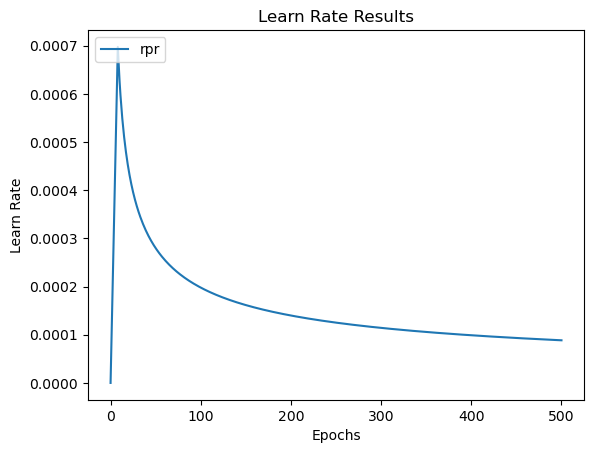

In [4]:
#@title Graph the results
import argparse
import os
import csv
import math
import matplotlib.pyplot as plt

RESULTS_FILE = "results.csv"
EPOCH_IDX = 0
LR_IDX = 1
EVAL_LOSS_IDX = 4
EVAL_ACC_IDX = 5

SPLITTER = '?'


def graph_results(input_dirs="./output/results", output_dir="./output/results", model_names=None, epoch_start=0, epoch_end=None):
    """
    ----------
    Author: Damon Gwinn
    ----------
    Graphs model training and evaluation data
    ----------
    """

    input_dirs = input_dirs.split(SPLITTER)

    if(model_names is not None):
        model_names = model_names.split(SPLITTER)
        if(len(model_names) != len(input_dirs)):
            print("Error: len(model_names) != len(input_dirs)")
            return

    #Initialize Loss and Accuracy arrays
    loss_arrs = []
    accuracy_arrs = []
    epoch_counts = []
    lrs = []

    for input_dir in input_dirs:
        loss_arr = []
        accuracy_arr = []
        epoch_count = []
        lr_arr = []

        f = os.path.join(input_dir, RESULTS_FILE)
        with open(f, "r") as i_stream:
            reader = csv.reader(i_stream)
            next(reader)

            lines = [line for line in reader]

        if(epoch_end is None):
            epoch_end = math.inf

        epoch_start = max(epoch_start, 0)
        epoch_start = min(epoch_start, epoch_end)

        for line in lines:
            epoch = line[EPOCH_IDX]
            lr = line[LR_IDX]
            accuracy = line[EVAL_ACC_IDX]
            loss = line[EVAL_LOSS_IDX]

            if(int(epoch) >= epoch_start and int(epoch) < epoch_end):
                accuracy_arr.append(float(accuracy))
                loss_arr.append(float(loss))
                epoch_count.append(int(epoch))
                lr_arr.append(float(lr))

        loss_arrs.append(loss_arr)
        accuracy_arrs.append(accuracy_arr)
        epoch_counts.append(epoch_count)
        lrs.append(lr_arr)

    if(output_dir is not None):
        try:
            os.mkdir(output_dir)
        except OSError:
            print ("Creation of the directory %s failed" % output_dir)
        else:
            print ("Successfully created the directory %s" % output_dir)

    ##### LOSS #####
    for i in range(len(loss_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], loss_arrs[i], label=name)
        plt.title("Loss Results")
        plt.ylabel('Loss (Cross Entropy)')
        plt.xlabel('Epochs')
        fig1 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig1.savefig(os.path.join(output_dir, 'loss_graph.png'))

    plt.show()

    ##### ACCURACY #####
    for i in range(len(accuracy_arrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], accuracy_arrs[i], label=name)
        plt.title("Accuracy Results")
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'accuracy_graph.png'))

    plt.show()

    ##### LR #####
    for i in range(len(lrs)):
        if(model_names is None):
            name = None
        else:
            name = model_names[i]

        #Create and save plots to output folder
        plt.plot(epoch_counts[i], lrs[i], label=name)
        plt.title("Learn Rate Results")
        plt.ylabel('Learn Rate')
        plt.xlabel('Epochs')
        fig2 = plt.gcf()

    plt.legend(loc="upper left")

    if(output_dir is not None):
        fig2.savefig(os.path.join(output_dir, 'lr_graph.png'))

    plt.show()
graph_results(model_names='rpr')

To have the model continue your custom MIDI enter the following into the custom_MIDI field below:

-primer_file '/content/some_dir/some_seed_midi.mid'

For example: -primer_file '/content/MusicTransformer-Pytorch/seed.mid'

# Generate and Explore the output :)

In [3]:
#@title Generate, Plot, Graph, Save, Download, and Render the resulting output
number_of_tokens_to_generate = 1023 #@param {type:"slider", min:1, max:2048, step:1}
priming_sequence_length = 65 #@param {type:"slider", min:1, max:2048, step:8}
maximum_possible_output_sequence = 2048 #@param {type:"slider", min:0, max:2048, step:8}
select_model = "./output/results/best_acc_weights.pickle" #@param ["/content/MusicTransformer-Pytorch/rpr/results/best_acc_weights.pickle", "/content/MusicTransformer-Pytorch/rpr/results/best_loss_weights.pickle"]
custom_MIDI = "" #@param {type:"string"}

import processor
from processor import encode_midi, decode_midi

!python generate.py -output_dir ./output/Generated -model_weights=$select_model -target_seq_length=$number_of_tokens_to_generate -num_prime=$priming_sequence_length -max_sequence=$maximum_possible_output_sequence #$custom_MIDI #

print('Successfully exported the output to output folder. To primer.mid and rand.mid')


midi_root: ./dataset
output_dir: ./output/Generated
primer_file: None
force_cpu: False

target_seq_length: 1023
num_prime: 65
model_weights: ./output/results/best_acc_weights.pickle
beam: 0

rpr: False
max_sequence: 2048
n_layers: 6
num_heads: 8
d_model: 512

dim_feedforward: 1024

Using primer index: 43 ( ./dataset/test/Anger/0dcaa15e668621bca5b1bf7532d45e2b.mid.pickle )
RAND DIST
Generating sequence of max length: 1023
100 / 1023
150 / 1023
200 / 1023
250 / 1023
300 / 1023
350 / 1023
400 / 1023
450 / 1023
500 / 1023
550 / 1023
600 / 1023
650 / 1023
700 / 1023
750 / 1023
800 / 1023
850 / 1023
900 / 1023
950 / 1023
1000 / 1023
Successfully exported the output to output folder. To primer.mid and rand.mid


In [ ]:
#@title Plot and Graph the Output :)
graphs_length_inches = 18 #@param {type:"slider", min:0, max:20, step:1}
notes_graph_height = 6 #@param {type:"slider", min:0, max:20, step:1}
highest_displayed_pitch = 92 #@param {type:"slider", min:1, max:128, step:1}
lowest_displayed_pitch = 24 #@param {type:"slider", min:1, max:128, step:1}
piano_roll_color_map = "Blues"

import librosa
import numpy as np
import pretty_midi
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('SVG')
# For plotting
import mir_eval.display
import librosa.display
%matplotlib inline


midi_data = pretty_midi.PrettyMIDI('/content/MusicTransformer-Pytorch/output/rand.mid')

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))



roll = np.zeros([int(graphs_length_inches), 128])
# Plot the output

track = Multitrack('/content/MusicTransformer-Pytorch/output/rand.mid', name='track')
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
fig, ax = track.plot()
fig.set_size_inches(graphs_length_inches, notes_graph_height)
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
ax2 = plot_piano_roll(midi_data, int(lowest_displayed_pitch), int(highest_displayed_pitch))
plt.show(block=False)